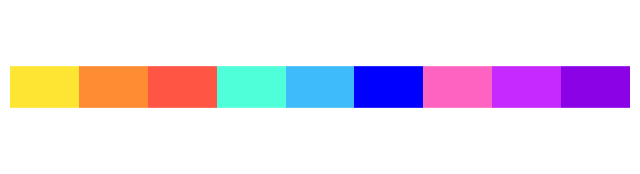

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import numpy as np

def draw_colors(colors):
    # Plot the colors as swatches
    plt.figure(figsize=(8, 2))
    for i, color in enumerate(colors):
        plt.plot([i, i+1], [0, 0], color=color, linewidth=30, solid_capstyle='butt')

    # Remove axes and set display limits
    plt.gca().axis('off')
    plt.xlim(0, len(colors))

    # Show the plot
    plt.show()

new_map = {    
        '1, 50000': "#ffe533",  # Slightly warmer yellow
        '1, 70000': "#ff8c33",  # Slightly deeper orange
        '1, 100000': "#ff5544",  # Slightly more vibrant red
         '2, 50000': "#4fffd9",
         '2, 70000': "#3ebbfa",
         '2, 100000': "#0000ff",
         '4, 50000': "#ff63c1",
         '4, 70000': "#c629ff",
         '4, 100000': "#8b02e6",
          }

draw_colors(new_map.values())

files = [   '../../../data/out_metrics/results_20250111_230040_lay_act_0_4.pkl',
         '../../../data/out_metrics/results_20250110_235015_lay_act_4_8.pkl',
         '../../../data/out_metrics/results_20250111_141338_lay_act_8_12.pkl',
        '../../../data/out_metrics/results_20250111_073045_lay_act_12_16.pkl',
        '../../../data/out_metrics/results_20250113_231645_lay_act_15_16.pkl',
         '../../../data/out_metrics/results_20250112_141019_lay_act_16_20.pkl',
         '../../../data/out_metrics/results_20250113_032700_lay_act_20_24.pkl',
         '../../../data/out_metrics/results_20250113_045901_lay_act_24_28.pkl',
         '../../../data/out_metrics/results_20250124_183809_lay_act_25_28.pkl',
         '../../../data/out_metrics/results_20250114_220059_lay_act_28_30.pkl',
         '../../../data/out_metrics/results_20250124_182839_lay_act_29_32.pkl', 
         '../../../data/out_metrics/results_20250113_155618_lay_act_32_36.pkl',
         '../../../data/out_metrics/results_20250122_041551_lay_act_33_34.pkl',
         '../../../data/out_metrics/results_20250114_191835_lay_act_34_35.pkl',
         '../../../data/out_metrics/results_20250122_160523_lay_act_35_36.pkl',
        ]

def savefig_and_show(figname):
    plt.savefig(
        figname+".png", format="png", dpi=600
    )
    plt.savefig(
        figname+".pdf", format="pdf"
    )
    plt.show()

import os
IMG_DIR = "../../img"

In [2]:
# ! mv '../../../data/out_metrics/results_20250124_183809_lay_act_27_28.pkl' '../../../data/out_metrics/results_20250124_183809_lay_act_25_28.pkl'
# ! mv '../../../data/out_metrics/results_20250124_182839_lay_act_31_32.pkl' '../../../data/out_metrics/results_20250124_182839_lay_act_29_32.pkl'
# ! mv '../../../data/out_metrics/losses_20250124_183809_lay_act_27_28.pkl' '../../../data/out_metrics/losses_20250124_183809_lay_act_25_28.pkl'
# ! mv '../../../data/out_metrics/losses_20250124_182839_lay_act_31_32.pkl' '../../../data/out_metrics/losses_20250124_182839_lay_act_29_32.pkl'

In [3]:
all_results = dict()
for file_name in files:
    with open(file_name, "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    
print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "accuracy": [],
    "capacity": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch+1) * 2)
            flattened_data["accuracy"].append(value)
            flattened_data["capacity"].append(int(value/100*n_rows))

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(lambda x: {'default': "ReLU", 'GELU':'GELU', 'RAF':"RReLU", 'softmax':'softmax'}[x])
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 36


,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity
0,ReLU,1,50000,0,2,9.968,4984
1,ReLU,1,50000,0,4,13.368,6684
2,ReLU,1,50000,0,6,62.674,31337
3,ReLU,1,50000,0,8,83.532,41766
4,ReLU,1,50000,0,10,92.164,46082
...,...,...,...,...,...,...,...
179995,softmax,4,100000,9,992,88.208,88208
179996,softmax,4,100000,9,994,88.199,88199
179997,softmax,4,100000,9,996,88.230,88230
179998,softmax,4,100000,9,998,88.245,88245


In [7]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "n_rows, num_layers": "layers amount, data size",
            "activation_function": "activation function",
        }
    )

    # Plot with Seaborn
    sns.set_style("white", rc={
    'xtick.bottom': True,
    'ytick.left': True,
    })

    plt.figure(figsize=(9, 5))
    
    
    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.9,
                linestyle="--",
                linewidth=0.9,   
            )

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="layers amount, data size",  # Combined hue for Num_Layers and N_rows
        style="activation function",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Experiment 2:", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks
        
    # Show the plot
    plt.tight_layout()

In [8]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


30


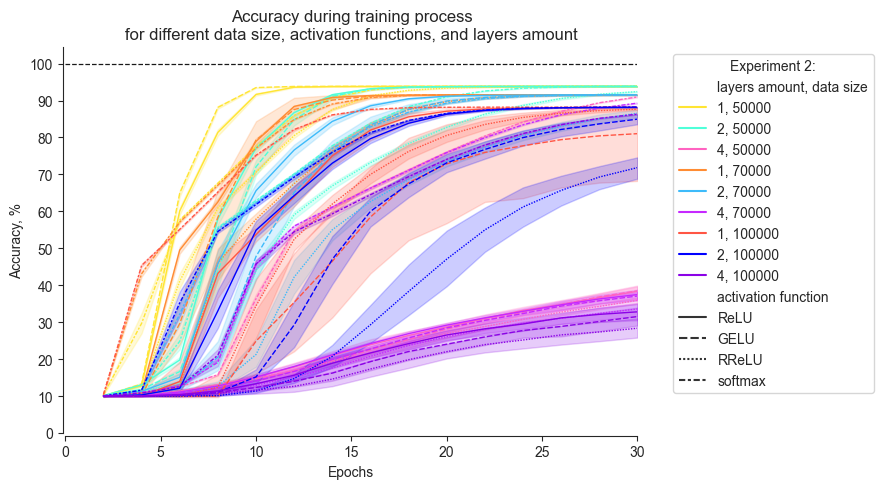

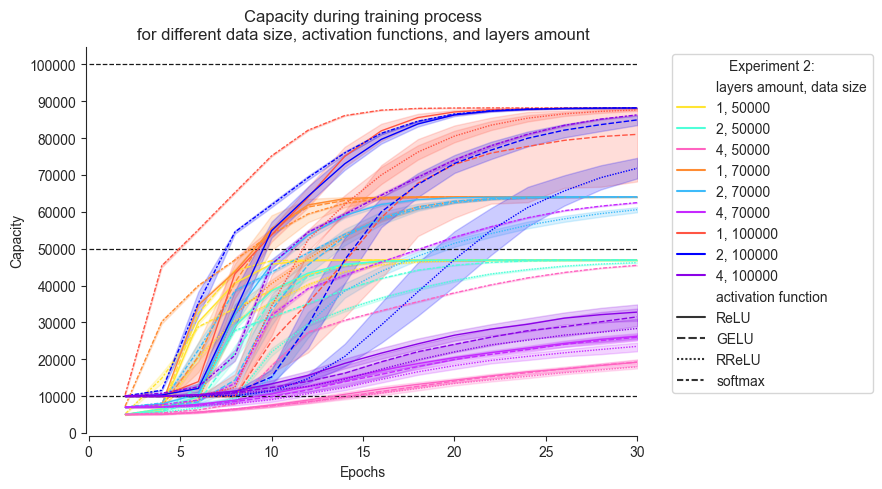

100


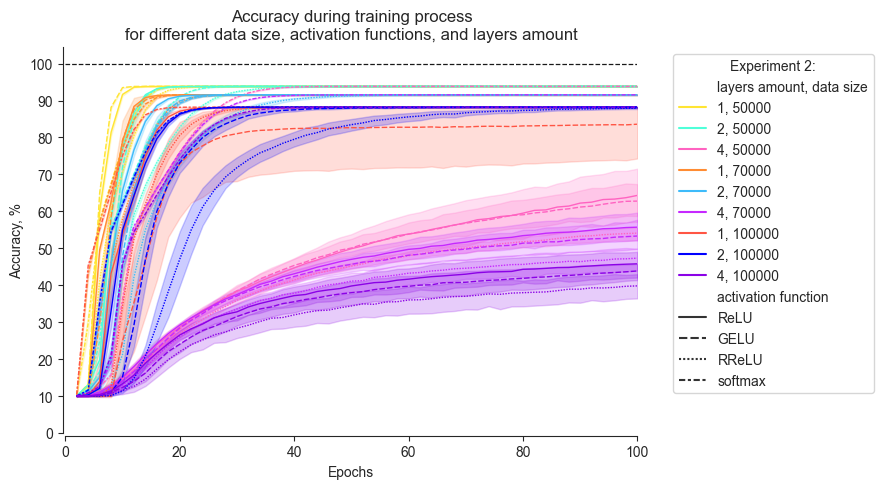

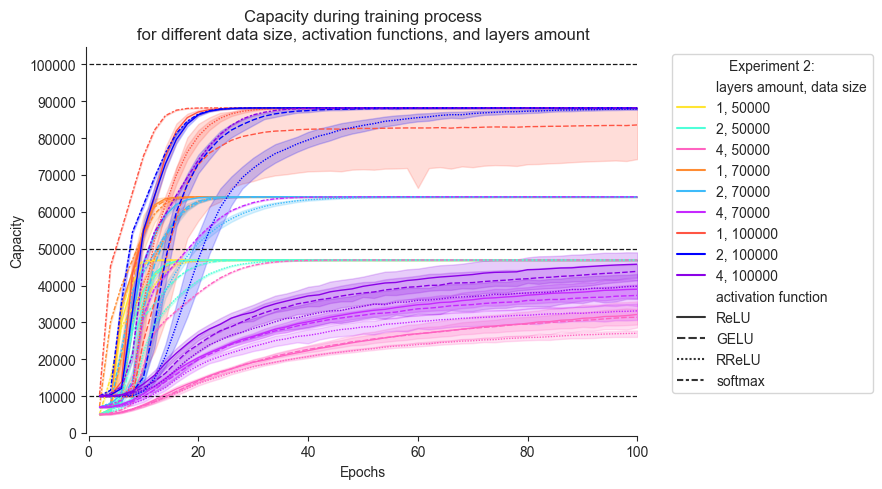

1000


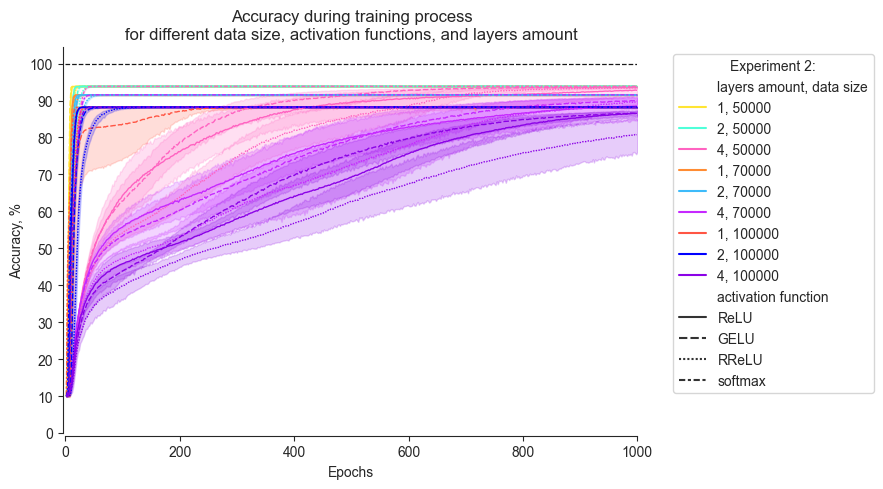

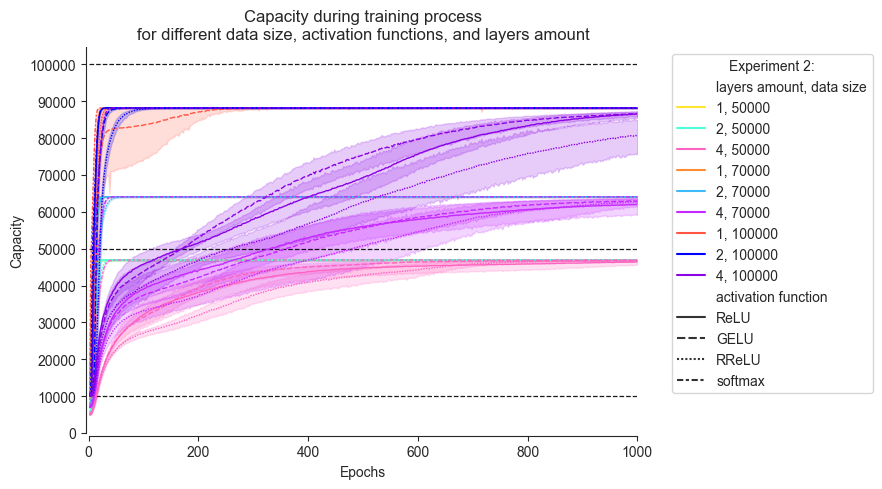

In [9]:
for epochs in [30, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        yticks=np.arange(0, 101, 10),
        y_lines=[100,],
        x="epochs",
        y="accuracy",
        xlabel="Epochs",
        ylabel="Accuracy, %",
        title="Accuracy during training process\nfor different data size, activation functions, and layers amount",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"2_layact_acc_{epochs}"))
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        yticks=np.arange(0, 100001, 10000),
        y_lines=[10000,50000, 100000],
        x="epochs",
        y="capacity",
        xlabel="Epochs",
        ylabel="Capacity",
        title="Capacity during training process\nfor different data size, activation functions, and layers amount",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"2_layact_cap_{epochs}"))

## Violins

In [7]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,activation_function,num_layers,n_rows,iteration,epochs,accuracy,capacity,"n_rows, num_layers"
499,ReLU,1,50000,0,1000,93.752,46875,"1, 50000"
999,ReLU,1,50000,1,1000,93.964,46982,"1, 50000"
1499,ReLU,1,50000,2,1000,93.756,46878,"1, 50000"
1999,ReLU,1,50000,3,1000,93.958,46979,"1, 50000"
2499,ReLU,1,50000,4,1000,93.458,46729,"1, 50000"


In [8]:
temp = deepcopy(data_viol)
temp.activation_function = 'all'

df = pd.concat([data_viol, temp]).set_index(['activation_function','num_layers'])[['n_rows', 'accuracy', 'capacity']]
grouped = (
    df.groupby(['activation_function', 'num_layers', 'n_rows'])
    .agg(accuracy_mean=('accuracy', 'mean'),
         accuracy_std=('accuracy', 'std'),
         capacity_mean=('capacity', 'mean'),
         capacity_std=('capacity', 'std'))
)

# Unstack to pivot `n_rows` into columns
final = grouped.unstack(level='n_rows')

# Create a MultiIndex for columns with the correct order
final.columns = pd.MultiIndex.from_tuples(
    [(n_rows, metric) for metric, n_rows in final.columns],
    names=["n_rows", "metric"]
)
# ORDER cols
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]

# ORDER rows
# Define the desired order for 'activation_function'
activation_order = ['ReLU', 'GELU', 'RReLU', 'softmax', 'all']

# Reorder rows based on the activation function order
final = final.loc[activation_order]

# Rearrange columns: first all related to 50000, then 70000
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]


final.round(2)

n_rows                                50000                              \
metric                         accuracy_mean accuracy_std capacity_mean   
activation_function num_layers                                            
ReLU                1                  93.80         0.16      46897.50   
                    2                  93.84         0.11      46920.10   
                    4                  92.78         2.27      46391.00   
GELU                1                  93.85         0.11      46924.50   
                    2                  93.85         0.11      46925.50   
                    4                  93.60         0.16      46797.60   
RReLU               1                  93.86         0.12      46929.80   
                    2                  93.85         0.12      46926.50   
                    4                  93.46         0.22      46729.90   
softmax             1                  93.85         0.09      46923.70   
                    2                  93.82         0.13      46908.00   
                    4                  93.85         0.10      46923.40   
all                 1                  93.84         0.12      46918.88   
                    2                  93.84         0.12      46920.02   
                    4                  93.42         1.17      46710.48   

n_rows                                             70000                \
metric                         capacity_std accuracy_mean accuracy_std   
activation_function num_layers                                           
ReLU                1                 78.83         91.56         0.14   
                    2                 56.05         91.55         0.09   
                    4               1133.99         88.47         6.06   
GELU                1                 52.72         91.57         0.13   
                    2                 57.28         91.54         0.09   
                    4                 78.04         89.93         1.36   
RReLU               1                 62.30         91.54         0.09   
                    2                 60.61         91.55         0.08   
                    4                111.67         89.74         2.63   
softmax             1                 43.41         91.55         0.12   
                    2                 63.34         91.54         0.10   
                    4                 52.07         91.55         0.09   
all                 1                 59.73         91.55         0.12   
                    2                 57.54         91.55         0.09   
                    4                584.38         89.92         3.42   

n_rows                                                           100000  \
metric                         capacity_mean capacity_std accuracy_mean   
activation_function num_layers                                            
ReLU                1               64091.00        96.22         88.15   
                    2               64085.70        64.88         88.22   
                    4               61930.80      4240.09         86.56   
GELU                1               64095.80        91.81         88.19   
                    2               64079.60        59.91         88.22   
                    4               62948.60       953.20         86.59   
RReLU               1               64080.40        60.86         88.18   
                    2               64087.80        58.54         88.21   
                    4               62817.50      1840.14         80.76   
softmax             1               64082.10        82.89         88.21   
                    2               64074.30        67.00         88.21   
                    4               64084.50        65.30         88.20   
all                 1               64087.32        81.02         88.18   
                    2               64081.85        60.46         88.21   
                    4               62945

In [9]:
def draw_violins(
    data_viol, 
    x, 
    y, 
    xlabel, 
    ylabel, 
    title, 
    yticks=None, 
    hue=None, 
    return_ax=False, 
    ax=None
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": list(new_map.values())[2::3],
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
        
        
    sns.set_style("white", rc={
        'xtick.bottom': True,
        'ytick.left': True,
    })
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False,
        scale="count", 
        alpha=0.3
    )
    plt.setp(ax.collections, alpha=0.6)
    ax = sns.stripplot(data_viol, **data_dict, legend=True, alpha=0.9)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        ax.set_yticks(yticks)  # Custom y-ticks
    if return_ax:
        return ax

In [10]:
int(data_viol.accuracy.min())

65

All together


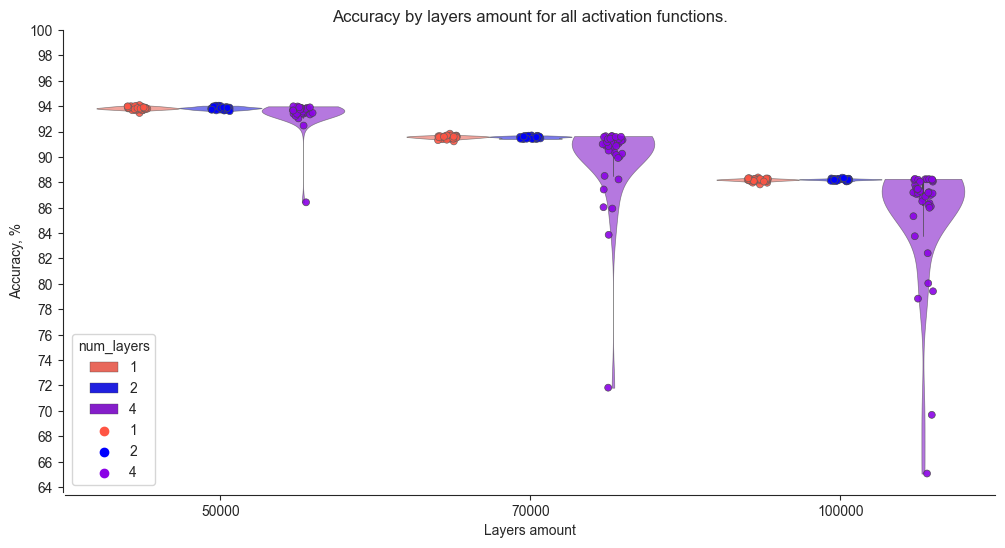

Separated


<Figure size 1400x400 with 0 Axes>

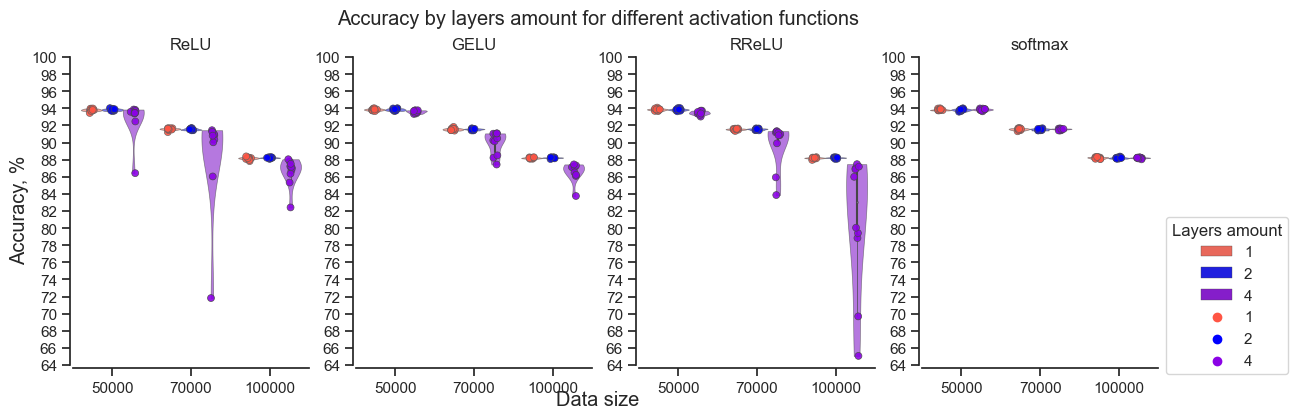

All together


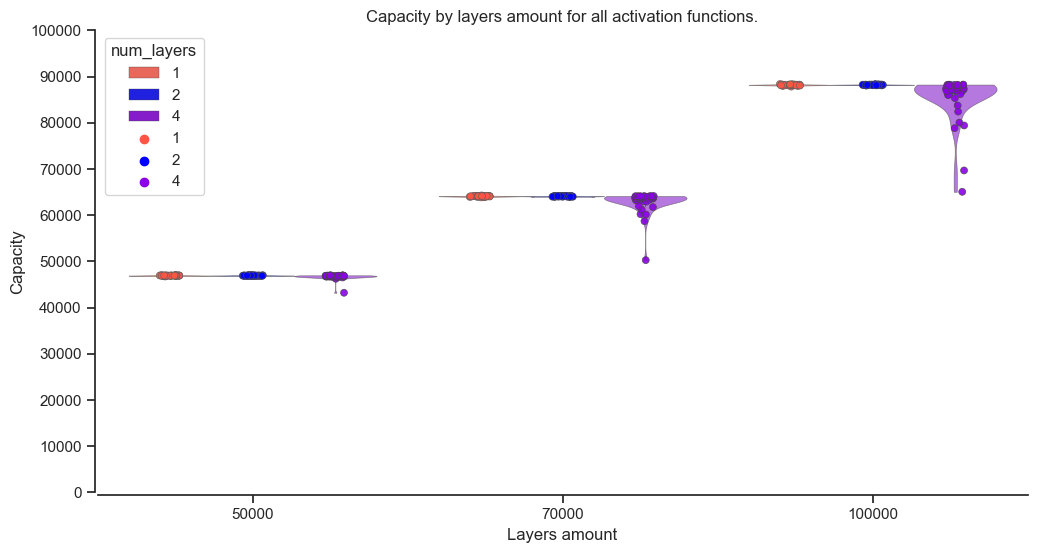

Separated


<Figure size 1400x400 with 0 Axes>

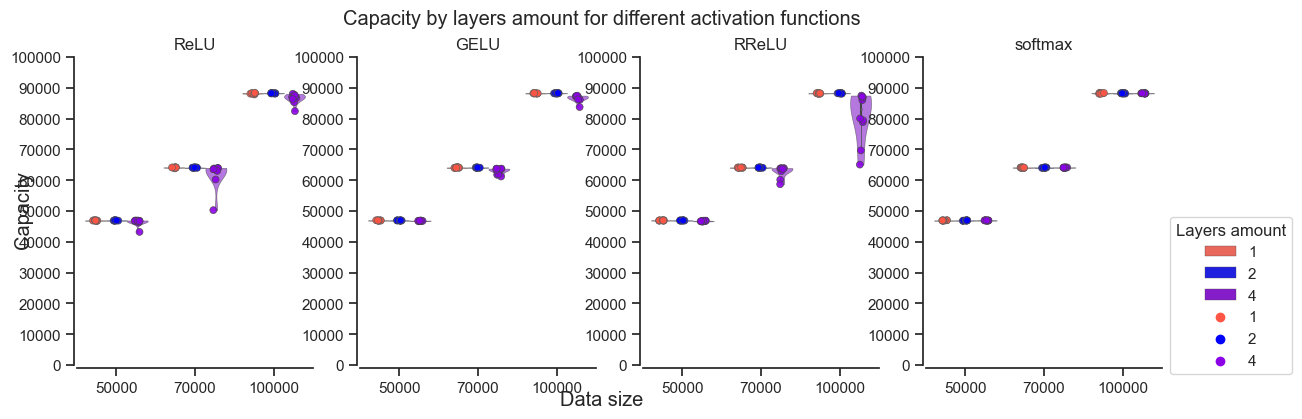

In [11]:
labels = [
    (
        "accuracy",
        "Accuracy, %",
        "Accuracy by layers amount for all activation functions.",
        "Accuracy by layers amount for different activation functions",
        np.arange(64, 101, 2)
    ),
    (
        "capacity",
        "Capacity",
        "Capacity by layers amount for all activation functions.",
        "Capacity by layers amount for different activation functions",
        np.arange(0, 100001, 10000)
    ),
]


for y, ylabel, title, title_separated, val_range in labels:
    print("All together")
    plt.figure(figsize=(12, 6))
    draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title,
        hue="num_layers",
        yticks=val_range
    )
    plt.show()
    # ==================================================
    print("Separated")
    sns.set(rc={"figure.figsize": (14, 4)})
    # get legend
    ax = draw_violins(
        data_viol,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=title_separated,
        hue="num_layers",
        return_ax=True,
        yticks=val_range
    )
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=1, ncols=4)
    for i, act_f in enumerate(data_viol.activation_function.unique()):
        row = i // 4
        col = i % 4
        cur_data = data_viol[data_viol.activation_function == act_f]
        ax = draw_violins(
            cur_data,
            x="n_rows",
            y=y,
            xlabel="Layers amount",
            ylabel=ylabel,
            title=f"`{act_f}`.",
            hue="num_layers",
            return_ax=True,
            ax=axs[col],
            yticks=val_range
        )
#         plt.setp(ax.collections, alpha=0.58)
        ax.legend_.remove()
        ax.set(ylabel="", xlabel="", title=act_f)
        ax.set(ylim=(min(val_range), max(val_range)))
        ax
    fig.supylabel(ylabel, y=0.5, x=0.08)
    fig.supxlabel("Data size", y=0, x=0.5)
    fig.suptitle(title_separated, y=1, x=0.5)
    fig.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.9, 0.5),
        title="Layers amount",
    )
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2
    )
    plt.show()